In [26]:
%reload_ext autoreload
%autoreload 2

import os
import argparse
import sys
import time
import cv2

from joblib import Parallel, delayed

sys.path.append(os.path.join(os.environ['GORDON_REPO_DIR'], 'utilities'))
from utilities2015 import *

from matplotlib.path import Path
%matplotlib inline

import scipy.ndimage as nd
import scipy

from skimage.feature import hog
from skimage import data, color, exposure
from sklearn.cluster import KMeans
from sklearn import svm

import random

In [55]:
X = np.load('/oasis/projects/nsf/csd395/ruogu/svm/X.npy');
y = np.load('/oasis/projects/nsf/csd395/ruogu/svm/y.npy');

In [56]:
print "%s" %(X.shape,);
print "%s" %(y.shape,);

(28571, 4200)
(28571,)


In [66]:
raw_data = zip(X, y);
print type(raw_data);

<type 'numpy.int64'>


In [93]:
data = [];
for i in range(0, 10):
    data_for_class = [x for x in raw_data if x[-1] == i];
    data = data + random.sample(data_for_class, 100);
# data is a list of (ndarray, int)
random.shuffle(data);

In [94]:
training_data = data[:750];
testing_data = data[750:];

In [105]:
training_X = np.asarray([x[0] for x in training_data]);
training_y = np.asarray([x[1] for x in training_data]);
testing_X = np.asarray([x[0] for x in testing_data]);
testing_y = np.asarray([x[1] for x in testing_data]);

In [108]:
print "Shape of training data: %s" %(training_X.shape,);
print "Shape of training label: %s" %(training_y.shape,);
print "Shape of testing data: %s" %(testing_X.shape,);
print "Shape of testing label: %s" %(testing_y.shape,);

Shape of training data: (750, 4200)
Shape of training label: (750,)
Shape of testing data: (250, 4200)
Shape of testing label: (250,)


In [100]:
# Calculate histogram intersection kernel
myKernel = np.zeros(shape=(len(training_data), len(training_data)));
for i in range(0, len(training_data)):
    for j in range(0, len(training_data)):
        myKernel[i][j] = sum(np.minimum(training_X[i], training_X[j]));

In [102]:
print "kernel shape: %s" %(myKernel.shape,);

kernel shape: (750, 750)


In [103]:
# Train SVM
clf = svm.SVC(kernel="precomputed");
clf.fit(myKernel, training_y);

In [119]:
# Training accuracy
predict_labels = clf.predict(myKernel);
n_correct = 0;
for i in range(len(training_data)):
    if predict_labels[i] == training_y[i]:
        n_correct += 1;
print (1.0*n_correct / len(training_data));

0.544


In [110]:
# Test
testKernel = np.zeros(shape=(len(testing_data), len(training_data)));
for i in range(0, len(testing_data)):
    for j in range(0, len(training_data)):
        myKernel[i][j] = sum(np.minimum(testing_X[i], training_X[j]));

In [112]:
confusion = np.zeros(shape=(10, 10), dtype=np.int);
total = len(testing_data);
n_correct = 0;
for i in range(total):
    confusion[predict_labels[i]][testing_y[i]] += 1;
    if (predict_labels[i] == testing_y[i]):
        n_correct += 1;
print (1.0*n_correct / total);

0.096


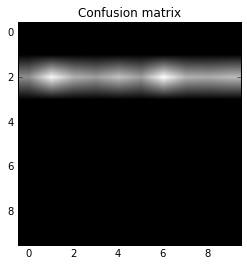

In [122]:
plt.figure(figsize=(4, 4));
plt.imshow(confusion, cmap=plt.cm.gray);
#plt.axis('off');
plt.title('Confusion matrix');